In [1]:
!module load cuda proxy
!nvcc -V
!nvidia-smi
!export CUDA_VISIBLE_DEVICES=7

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Nov_22_10:17:15_PST_2023
Cuda compilation tools, release 12.3, V12.3.107
Build cuda_12.3.r12.3/compiler.33567101_0
Tue Nov 12 18:01:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A40                     On  | 00000000:01:00.0 Off |                    0 |
|  0%   71C    P0             233W / 30

In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np

from stacathome import MaxiCube

import segmentation_models_pytorch as smp
import torch
import xarray as xr
from torch.utils.model_zoo import load_url



In [69]:

def get_checkpoint(bands_avail):

    bands_avail = set(bands_avail)
    bands_all = ["B01",
                 "B02",
                 "B03",
                 "B04",
                 "B05",
                 "B06",
                 "B07",
                 "B8A",
                 "B09",
                 "B11",
                 "B12",
                 "AOT",
                 "WVP"]
    bands_min = ["B02", "B03", "B04", "B8A"]
    if set(bands_all).issubset(bands_avail):
        ckpt = load_url(
            "https://nextcloud.bgc-jena.mpg.de/s/qHKcyZpzHtXnzL2/download/mobilenetv2_l2a_all.pth"
        )
        ckpt_bands = bands_all
    elif set(bands_min).issubset(bands_avail):
        ckpt = load_url(
            "https://nextcloud.bgc-jena.mpg.de/s/Ti4aYdHe2m3jBHy/download/mobilenetv2_l2a_rgbnir.pth"
        )
        ckpt_bands = bands_min
    else:
        raise Exception(
            f"The bands {bands_avail} do not contain the necessary bands for cloud masking."
            "Please include at least bands B02, B03, B04 and B8A."
        )
        ckpt = None
        ckpt_bands = None

    return ckpt, ckpt_bands


class CloudMask:
    def __init__(
        self,
        bands=["B02", "B03", "B04", "B8A"],
        cloud_mask_rescale_factor=None,
        device="cpu",
    ):

        self.cloud_mask_rescale_factor = cloud_mask_rescale_factor
        self.bands = bands
        ckpt, self.ckpt_bands = get_checkpoint(bands)
        self.device = device

        self.model = smp.Unet(
            encoder_name="mobilenet_v2",
            encoder_weights=None,
            classes=4,
            in_channels=len(self.ckpt_bands),
        ).to(self.device)

        if ckpt:
            self.model.load_state_dict(ckpt)

        self.model.eval()

        self.bands_scale = xr.DataArray(
            12
            * [
                10000,
            ]
            + [65535, 65535, 1],
            coords={
                "band": [
                    "B01",
                    "B02",
                    "B03",
                    "B04",
                    "B05",
                    "B06",
                    "B07",
                    "B08",
                    "B8A",
                    "B09",
                    "B11",
                    "B12",
                    "AOT",
                    "WVP",
                    "SCL",
                ]
            },
        )

    def __call__(self, stack):

        ds = stack.to_dataset("band")

        x = torch.from_numpy(
            (stack.sel(band=self.ckpt_bands) / self.bands_scale)
            .fillna(1.0)
            .transpose("time", "band", "y", "x")
            .values.astype("float32")
        ).to(self.device)

        b, c, h, w = x.shape

        h_big = (h // 32 + 1) * 32
        h_pad_left = (h_big - h) // 2
        h_pad_right = ((h_big - h) + 1) // 2

        w_big = (w // 32 + 1) * 32
        w_pad_left = (w_big - w) // 2
        w_pad_right = ((w_big - w) + 1) // 2

        x = torch.nn.functional.pad(
            x, (w_pad_left, w_pad_right, h_pad_left, h_pad_right), mode="reflect"
        )

        if self.cloud_mask_rescale_factor:
            # orig_size = (x.shape[-2], x.shape[-1])
            x = torch.nn.functional.interpolate(
                x, scale_factor=self.cloud_mask_rescale_factor, mode="bilinear"
            )

        with torch.no_grad():
            y_hat = self.model(x)

        y_hat = torch.argmax(y_hat, dim=1).float()

        if self.cloud_mask_rescale_factor:
            y_hat = torch.nn.functional.max_pool2d(
                y_hat[:, None, ...], kernel_size=self.cloud_mask_rescale_factor
            )[
                :, 0, ...
            ]  # torch.nn.functional.interpolate(y_hat, size = orig_size, mode = "bilinear")

        y_hat = y_hat[:, h_pad_left:-h_pad_right, w_pad_left:-w_pad_right]

        # ds["mask"] = (("time", "y", "x"), y_hat.cpu().numpy())

        return y_hat.cpu().numpy()  # ds.to_array("band").where(ds[self.ckpt_bands[0]].notnull(), np.nan)


def cloud_mask_reduce(x, axis=None, **kwargs):
    return np.where(
        (x == 1).any(axis=axis),
        1,
        np.where(
            (x == 3).any(axis=axis),
            3,
            np.where(
                (x == 2).any(axis=axis), 2, np.where((x == 0).any(axis=axis), 0, 4)
            ),
        ),
    )


In [22]:
aoi = 'somalia'
requested_bands = ['B02', 'B03', 'B04', 'B8A']
resolution = 0.00018  # 20  # 0.00018
crs = 4326  # 32737  # 4326
chunksize_xy = 256
chunksize_t = 1000

out_path = '/Net/Groups/BGI/data/DataStructureMDI/DATA/Incoming/Sentinel/_2/S2A_L2A/ForSites/Sentinel2tiles'
os.makedirs(out_path, exist_ok=True)

zarr_store = '/Net/Groups/BGI/scratch/mzehner/VCI_Somalia/Somalia_S2_2014_2026.zarr'

mxc = MaxiCube(aoi=aoi,
               requested_bands=requested_bands,
               crs=crs,
               resolution=resolution,
               chunksize_xy=chunksize_xy,
               chunksize_t=chunksize_t,
               path=out_path,
               zarr_path=zarr_store,
               )

Loading local assets
Zarr already exists at /Net/Groups/BGI/scratch/mzehner/VCI_Somalia/Somalia_S2_2014_2026.zarr. Skipping creation. Set overwrite=True to overwrite.


In [95]:
'/'.join(next(iter(mxc.items_local_global[0].assets.values())).href.split('/')[:-5])

'/Net/Groups/BGI/data/DataStructureMDI/DATA/Incoming/Sentinel/_2/S2A_L2A/ForSites/Sentinel2tiles/S2B_MSIL2A_20240823T065619_N0511_R063_T38PRR_20240823T113539.SAFE'

In [165]:
import rasterio
import stackstac as ss


def prior_check_cloud_mask(item, bands=['B02', 'B03', 'B04', 'B8A']):
    if not set(bands).issubset(set(item.assets.keys())): 
        return False, 'missing bands'
    
    path_out = item.assets[bands[0]].href[:-11] + 'MSK' + item.assets[bands[0]].href[-8:]

    if os.path.exists(path_out):
        return False, 'exists'
    return True, 'do'

def run_cloud_mask(item, cm, bands=['B02', 'B03', 'B04', 'B8A']):
    if not set(bands).issubset(set(item.assets.keys())): 
        return ('/'.join(next(iter(item.assets.values())).href.split('/')[:-5]), 'missing bands')
    
    path_out = item.assets[bands[0]].href[:-11] + 'MSK' + item.assets[bands[0]].href[-8:]

    if os.path.exists(path_out):
        return ('/'.join(item.assets[bands[0]].href.split('/')[:-5]), 'exists')


    # cm = CloudMask(device='cpu')
    masked = cm(ss.stack(item, assets=bands))
    # check 

    # Open the original raster file to get its metadata
    with rasterio.open(item.assets['B02'].href) as src:
        original_meta = src.meta.copy()  # Copy metadata from the source raster

    # Suppose `array` is your numpy array (e.g., shape = (bands, height, width))
    # Ensure it matches the shape and dtype you intend to write

    # Update metadata if the array shape differs
    # If `array` has a different number of bands, update "count"
    # For example, if array has 3 bands:
    masked = masked.astype('uint8')  # Replace with your numpy array
    original_meta.update({
        "count": masked.shape[0],  # Number of bands
        "height": masked.shape[1],  # Rows
        "width": masked.shape[2],   # Columns
        "dtype": masked.dtype.name  # Data type (e.g., 'uint8', 'float32')
    })

    # Write the array to disk using the original metadata
    with rasterio.open(path_out, "w", **original_meta) as dest:
        dest.write(masked)  # Write all bands at once if `array` is 3D (bands, height, width)
    
    return ('/'.join(next(iter(item.assets.values())).href.split('/')[:-5]), 'done')

In [121]:
import dask
from dask.distributed import Client as daskClient
from dask_jobqueue import SLURMCluster

In [158]:
cluster = SLURMCluster(
    queue='work',
    cores=1,
    processes=1,
    memory='64GB',
    walltime='00:30:00',
    job_script_prologue=[
        'module load BGC-easybuilded',
        'module load  GCC',
    ]
    
)
cluster.scale(4)
client = daskClient(cluster)
cluster

/Net/Groups/BGI/scratch/mzehner/envs/minicuber/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33053 instead
  warnings.warn(


Dashboard: http://10.0.30.41:33053/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.30.41:34861,Workers: 0
Dashboard: http://10.0.30.41:33053/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [166]:
tasks = []
cm = CloudMask(device='cpu')
for i in mxc.items_local_global[:20]:
    print(prior_check_cloud_mask(i))
    if prior_check_cloud_mask(i)[0]:
        #tasks.append(client.submit(run_cloud_mask, i))
        run_cloud_mask(i, cm)

(False, 'exists')
(False, 'missing bands')
(False, 'exists')
(False, 'exists')
(False, 'exists')
(False, 'exists')
(False, 'exists')
(False, 'missing bands')
(False, 'exists')
(True, 'do')
(False, 'missing bands')
(True, 'do')
(True, 'do')
(False, 'missing bands')
(False, 'missing bands')
(True, 'do')


KeyboardInterrupt: 

In [162]:
tasks = client.gather(tasks)

KeyboardInterrupt: 

In [161]:
dask.compute(*tasks)

(<Future: pending, key: run_cloud_mask-736dcb14b98b9e26eb9f757592e4d458>,
 <Future: pending, key: run_cloud_mask-9e23105a33b764004eba1eb93d894fa7>,
 <Future: pending, key: run_cloud_mask-65b40c3cbb3a8d26eeb75899fd94b0db>,
 <Future: pending, key: run_cloud_mask-416a14341712fe95d04278e60d3664cd>,
 <Future: pending, key: run_cloud_mask-eb4a0660b427fa4bfa92bd4ab843265e>,
 <Future: pending, key: run_cloud_mask-1835f6b484630afaf55d1422032ae7bd>,
 <Future: pending, key: run_cloud_mask-1ec191d4c9db43574bad953ba575458d>,
 <Future: pending, key: run_cloud_mask-ca083a2064339aba4cd4dca7889ef424>,
 <Future: pending, key: run_cloud_mask-50bbdc8b642c38d87e494a21320561a0>)

In [163]:
client.close()
cluster.close()

Task exception was never retrieved
future: <Task finished name='Task-996593' coro=<Client._gather.<locals>.wait() done, defined at /Net/Groups/BGI/scratch/mzehner/envs/minicuber/lib/python3.12/site-packages/distributed/client.py:2395> exception=AllExit()>
Traceback (most recent call last):
  File "/Net/Groups/BGI/scratch/mzehner/envs/minicuber/lib/python3.12/site-packages/distributed/client.py", line 2404, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-996599' coro=<Client._gather.<locals>.wait() done, defined at /Net/Groups/BGI/scratch/mzehner/envs/minicuber/lib/python3.12/site-packages/distributed/client.py:2395> exception=AllExit()>
Traceback (most recent call last):
  File "/Net/Groups/BGI/scratch/mzehner/envs/minicuber/lib/python3.12/site-packages/distributed/client.py", line 2404, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-9

In [62]:
rasterio(masked.astype('uint8')).profile

TypeError: 'module' object is not callable

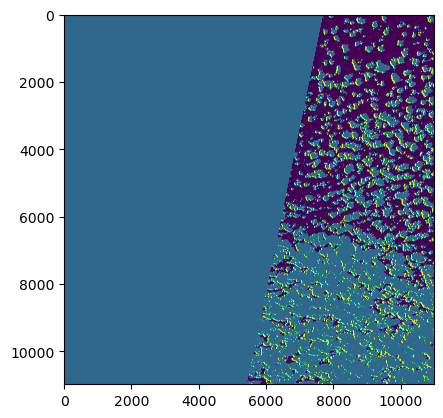

In [50]:
plt.imshow(masked.astype('uint8'))

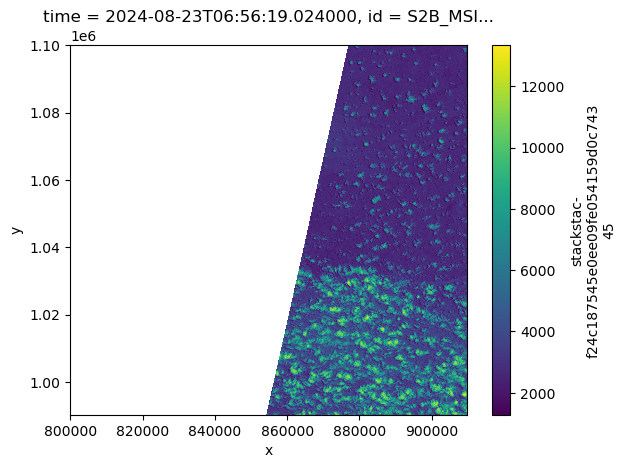

In [19]:
ss.stack(mxc.items_local_global[0]).isel(band=0).plot()

In [76]:
mxc.items_local_global[0].assets['MSK'] = mxc.items_local_global[0].assets['B02']

In [78]:
mxc.items_local_global[0]


<Item id=S2B_MSIL2A_20240823T065619_R063_T38PRR_20240823T113539>

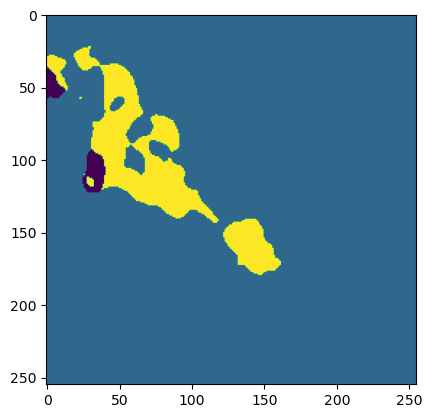

In [57]:
plt.imshow(masked.values[4][0])